In [1]:
import scipy.io
import numpy as np
from tqdm.auto import tqdm
mat_file_name = "./dataset/sEMG.mat"
mat_file = scipy.io.loadmat(mat_file_name)
emg = mat_file['emg']
label = mat_file['label']
rep = mat_file['repetition']

Text(0.5, 0, 'time(s)')

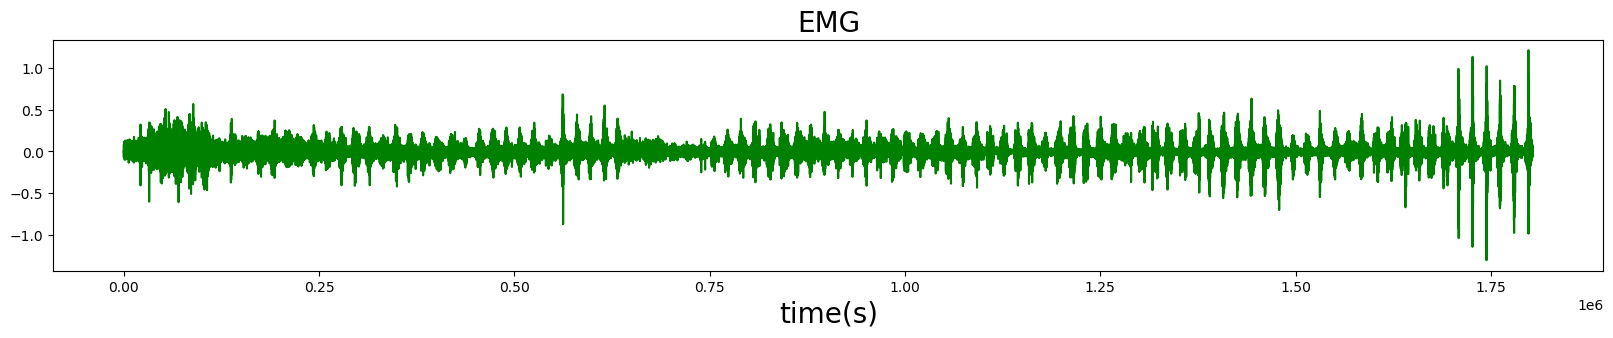

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,3))
plt.plot(emg[:,0], 'g')
plt.title('EMG', fontsize = 20)
plt.xlabel('time(s)', fontsize = 20)

Text(0.5, 0, 'time(s)')

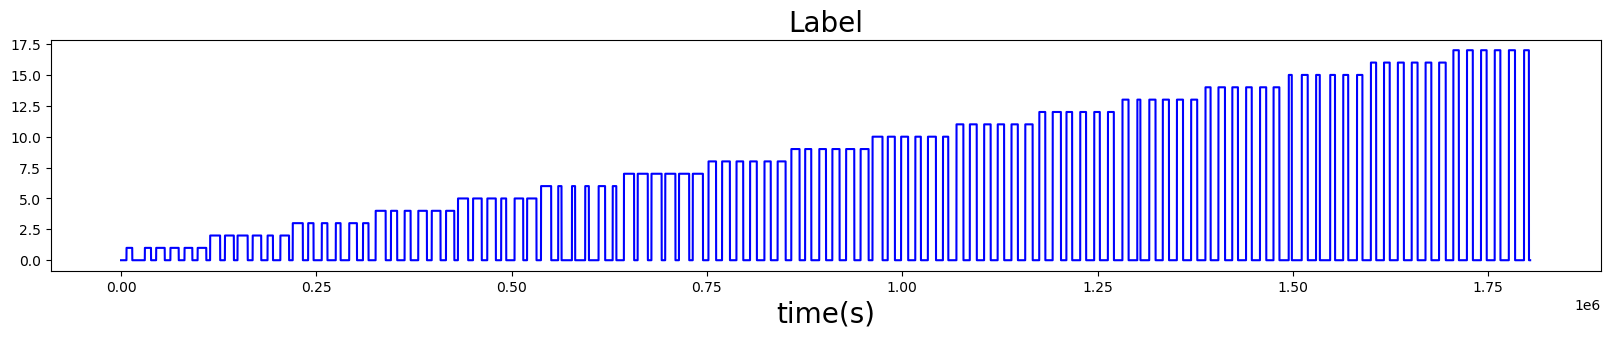

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,3))
plt.plot(label, 'b')
plt.title('Label', fontsize = 20)
plt.xlabel('time(s)', fontsize = 20)

Text(0.5, 0, 'time(s)')

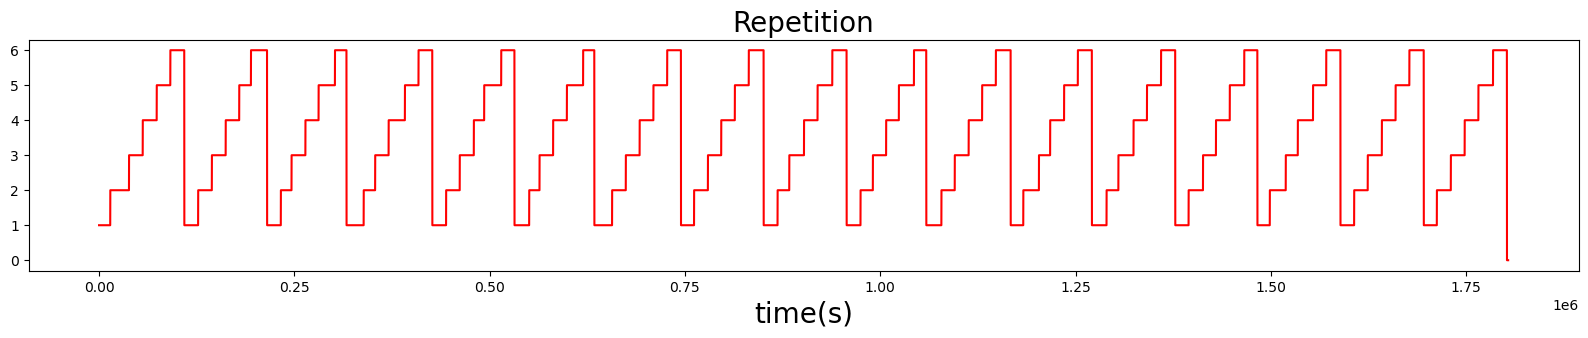

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,3))
plt.plot(rep, 'r')
plt.title('Repetition', fontsize = 20)
plt.xlabel('time(s)', fontsize = 20)

In [5]:
data = {} # Create Dictionary
for (l, r) in zip(label, rep):
    l, r = l.item(), r.item()
    if l == 0:
        continue
    data[(l, r)] = [] # Create Empty Value in Dictionary

for e, l, r in tqdm(zip(emg, label, rep), total = 1803711):
    l, r = l.item(), r.item()
    if l == 0:
        continue
    data[(l, r)].append(e) # Append EMG Value to Dictionary

  0%|          | 0/1803711 [00:00<?, ?it/s]

In [6]:
for i in data.keys():
    data[i] = np.stack(data[i])
    data[i] = data[i][:400 * (data[i].shape[0] // 400)] # 200ms(400 datas) segmentat
    data[i] = np.split(data[i], data[i].shape[0] // 400, axis = 0) # split in 200ms
    data[i] = np.array(data[i])

In [7]:
statistic = {} # Create Dictionary
for i in data.keys():
    mav = np.sum(np.abs(data[i]), axis = 1) / data[i].shape[1] # MAV
    var = np.sum(data[i] ** 2, axis = 1) / (data[i].shape[1] - 1) #VAR
    wl = np.sum(np.abs(np.diff(data[i], 1, axis = 1)), axis = 1) #WL
    
    statistic[i] = np.array([mav, var, wl]).transpose(1, 2, 0)

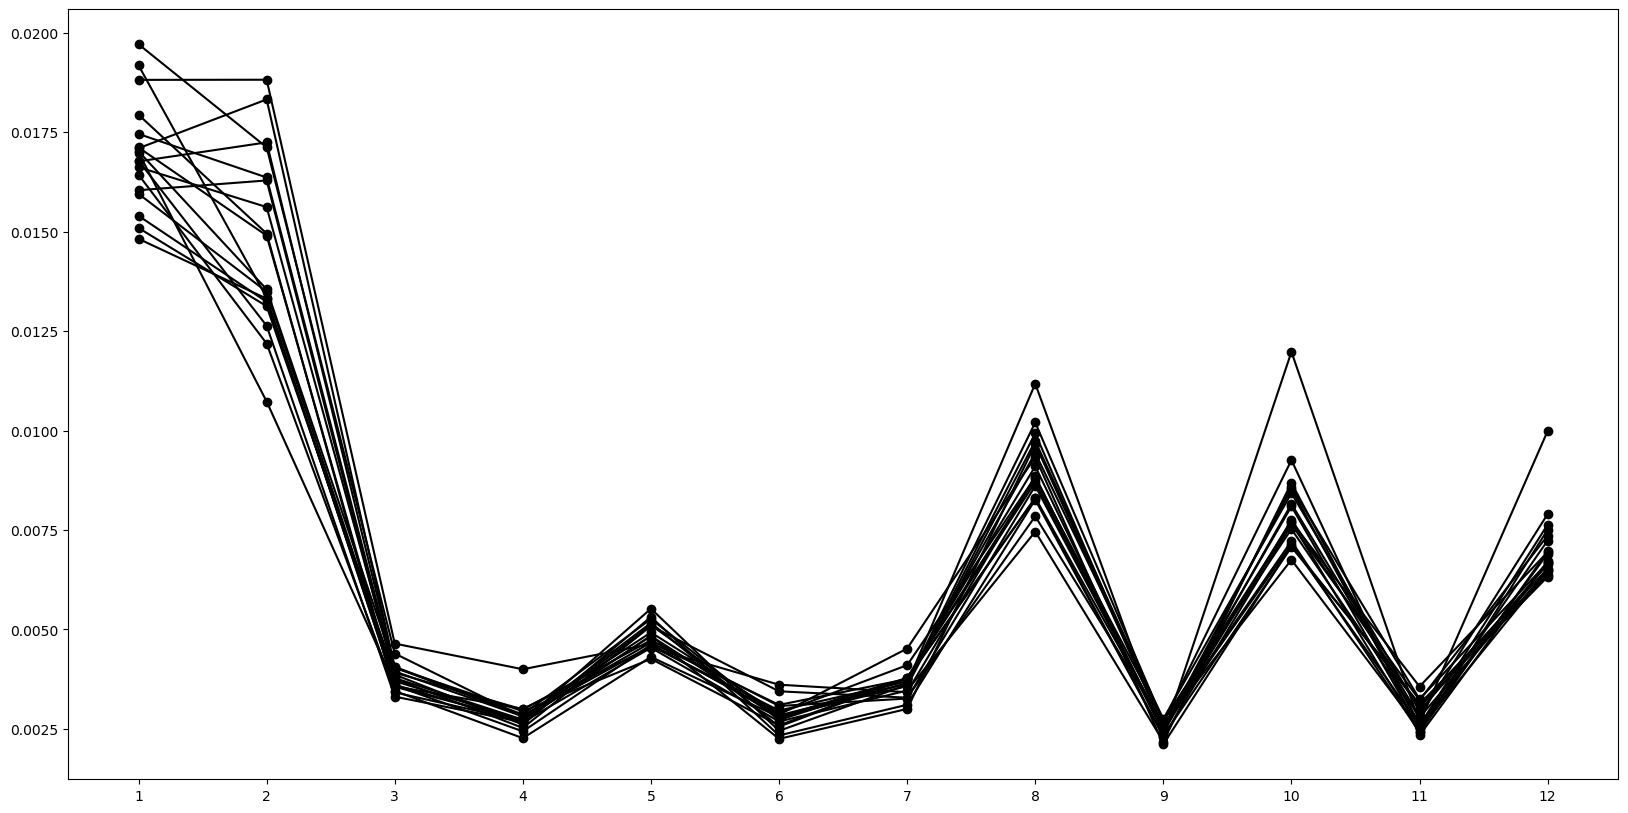

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

mav = np.vstack(statistic[(1, 1)]).reshape(-1, 36) # Change (1, 1) to (Class, Repeti
seg = mav.shape[0]
mav_value = []

for i in range(1, 13):
    for j in range(1, seg + 1):
        mav_value.append({"col" : i, "seg" : j, "val" : mav[j-1, 3 * (i - 1)]})
df = pd.DataFrame(mav_value)                            # MAV = 3 * (i - 1)
                                                        # VAR = 3 * (i - 1) + 1
channel = [f'{i}' for i in range(1, 13) ]              # WL = 3 * (i - 1) + 2
segment = [f'seg == {j}' for j in range(1, seg + 1)]

fig = plt.figure(figsize = (20,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

for i in range(len(segment)):
    df_n = df.query(segment[i])['val']
    ax.plot(channel, df_n, 'k', marker='o')

plt.show()

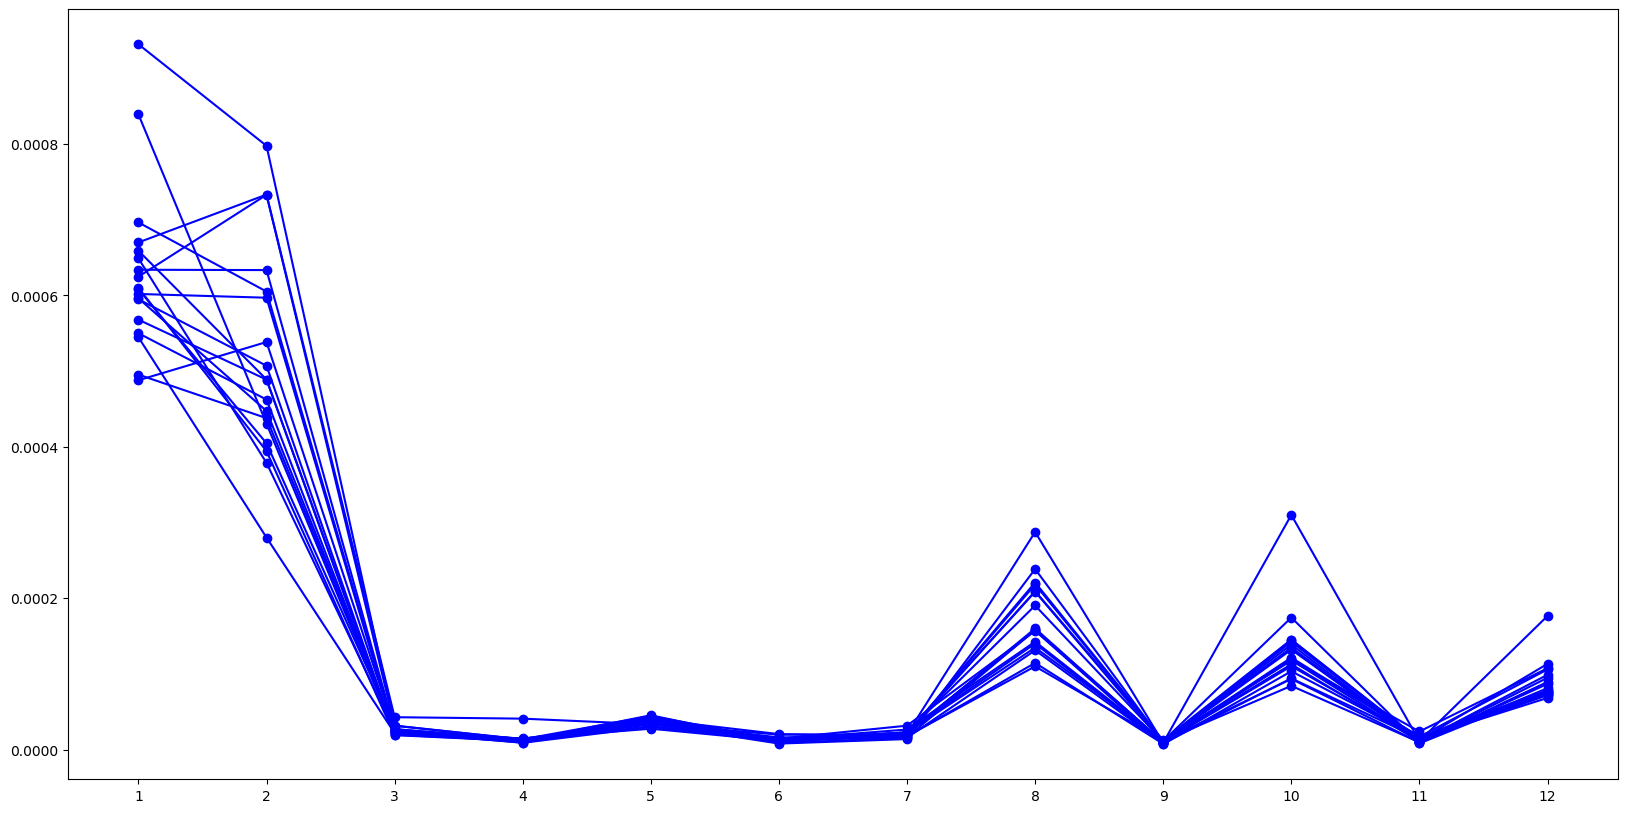

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

var = np.vstack(statistic[(1, 1)]).reshape(-1, 36)
seg = var.shape[0]
var_value = []

for i in range(1, 13):
    for j in range(1, seg + 1):
        var_value.append({"col" : i, "seg" : j, "val" : var[j-1, 3 * (i - 1) + 1]})
df = pd.DataFrame(var_value)

channel = [f'{i}' for i in range(1, 13) ]
segment = [f'seg == {j}' for j in range(1, seg + 1)]

fig = plt.figure(figsize = (20,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

for i in range(len(segment)):
    df_n = df.query(segment[i])['val']
    ax.plot(channel, df_n, 'b', marker='o')
    
plt.show()

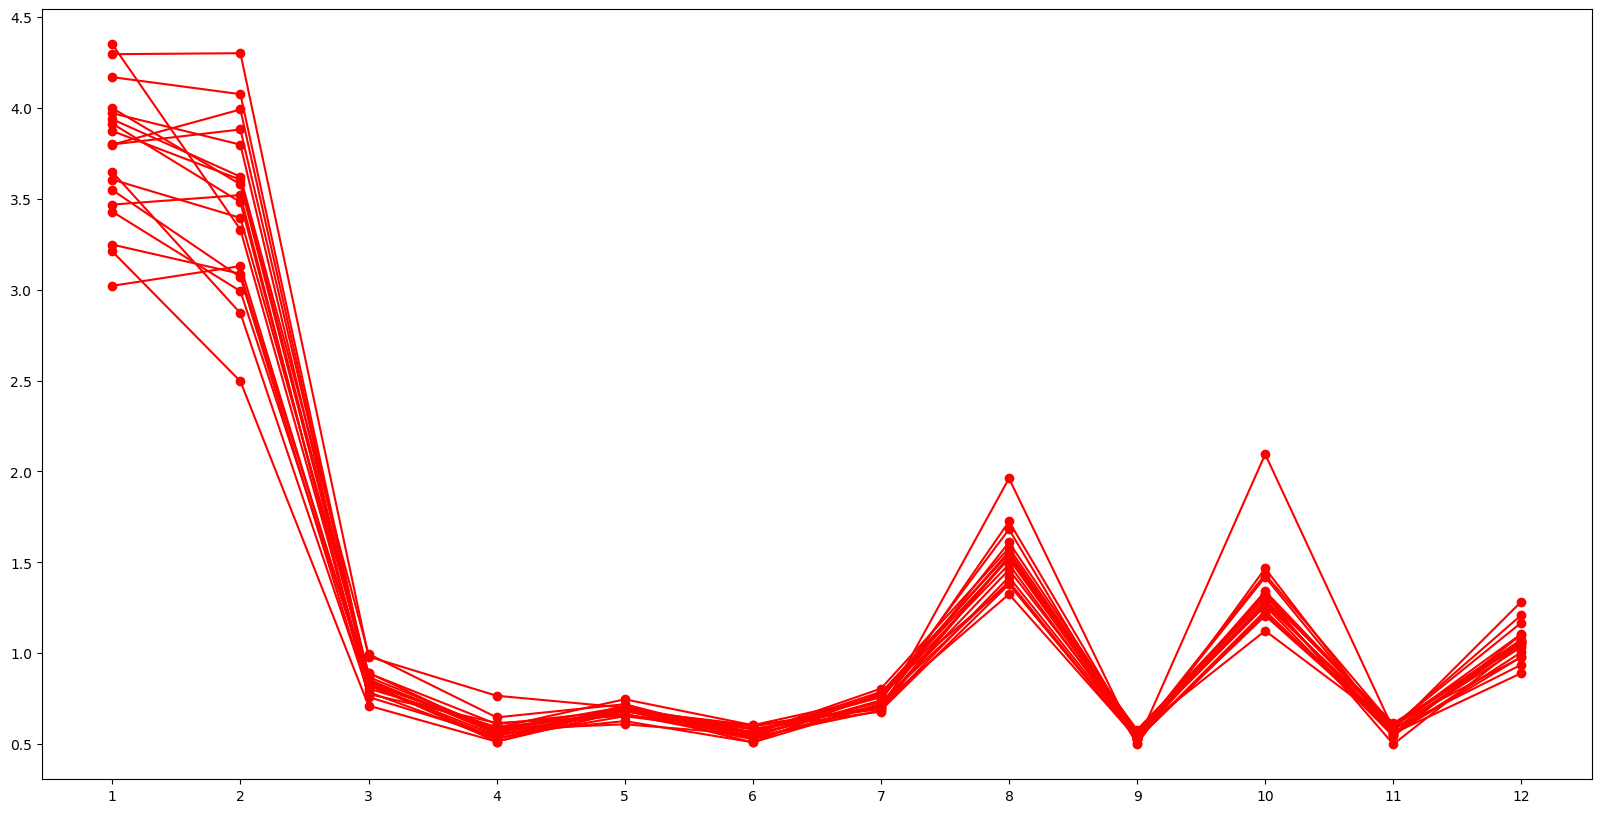

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

wl = np.vstack(statistic[(1, 1)]).reshape(-1, 36)
seg = wl.shape[0]
wl_value = []

for i in range(1, 13):
    for j in range(1, seg + 1):
        wl_value.append({"col" : i, "seg" : j, "val" : wl[j-1, 3 * (i - 1) + 2]})
df = pd.DataFrame(wl_value)

channel = [f'{i}' for i in range(1, 13) ]
segment = [f'seg == {j}' for j in range(1, seg + 1)]

fig = plt.figure(figsize = (20,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

for i in range(len(segment)):
    df_n = df.query(segment[i])['val']
    ax.plot(channel, df_n, 'r', marker='o')

plt.show()

In [11]:
train_X = []
train_Y = []
test_X = []
test_Y = []

for i in statistic.keys():
    (l, r) = i
    data = statistic[i]
    label = l * np.ones(data.shape[0])
    
    if r < 5:
        train_X.append(data)
        train_Y.append(label)
    else:
        test_X.append(data)
        test_Y.append(label)
        
train_X = np.vstack(train_X).reshape(-1, 36)
test_X = np.vstack(test_X).reshape(-1, 36)
train_Y = np.concatenate(train_Y)
test_Y = np.concatenate(test_Y)

In [12]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(handle_unknown = "ignore", sparse = False)
train_Y = onehot.fit_transform(train_Y.reshape(-1, 1))
test_Y = onehot.fit_transform(test_Y.reshape(-1, 1))

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

torch.manual_seed(777)

if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print('Using Pytorch version:', torch.__version__, ' Device:', device)

train_X = torch.as_tensor(train_X)
train_X = train_X.type(torch.FloatTensor)
test_X = torch.as_tensor(test_X)
test_X = test_X.type(torch.FloatTensor)
train_Y = torch.as_tensor(train_Y)
train_Y = train_Y.type(torch.LongTensor)
test_Y = torch.as_tensor(test_Y)
test_Y = test_Y.type(torch.LongTensor)

ds_train = TensorDataset(train_X, train_Y)
ds_test = TensorDataset(test_X, test_Y)

loader_train = DataLoader(ds_train, batch_size = 128, shuffle = True)
loader_test = DataLoader(ds_test, batch_size = 128, shuffle = False)

Using Pytorch version: 1.13.1+cpu  Device: cpu


In [14]:
from torch import nn

class Net(torch.nn.Module):
    def __init__(self, input_size, num_nuerons, output_size):
        super().__init__()
        self.layers = []
        layer_input = input_size
        for num in (num_nuerons):
            self.layers.append(nn.Linear(layer_input, num, bias = True))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.2))
            layer_input = num
        self.layers.append(nn.Linear(layer_input, output_size))
        self.layers = nn.ModuleList(self.layers)
    def forward(self, x):
        for f in self.layers:
            x = f(x)
        return x

In [15]:
from torch import optim

model = Net(36, [100, 100], 17).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()
model

Net(
  (layers): ModuleList(
    (0): Linear(in_features=36, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=100, out_features=17, bias=True)
  )
)

In [16]:
def iteration(model, loader, is_train, optimizer = None, criterion = None):
    if is_train:
        model.train()
    else:
        model.eval()
    
    true_labels, predictions, losses = [], [], []
    loss_value = 0.0
    
    for (x, y) in loader:
        x, y = x.to(device), y.to(device)
        if is_train:
            model.zero_grad()
        output = model(x)
        loss = criterion(output, y.float())
        loss_value += loss.item()
        if is_train:
            loss.backward()
            optimizer.step()
        _, pred = torch.max(output, 1)
        true_labels.extend(torch.argmax(y, dim = 1).tolist())
        predictions.extend(pred.tolist())
    loss_value /= len(loader)
    return np.array(true_labels), np.array(predictions), loss

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate(y_true, y_pred):
    return accuracy_score(y_true, y_pred), confusion_matrix(y_true, y_pred)

In [28]:
acc_trains, acc_tests, losses_trains = [], [], []

NUM_EPOCH = 2000
train_loop = tqdm(range(1, NUM_EPOCH+1))

for epoch in train_loop:
    true_labels_train, predictions_train, losses_train = iteration(model, loader_train, True, optimizer, criterion)
    acc_train, conf_train = evaluate(true_labels_train, predictions_train)
    acc_trains.append(acc_train)
    losses_trains.append(losses_train)
    
    true_labels_test, predictions_test, losses_test = iteration(model, loader_test, False, None, criterion)
    acc_test, conf_test = evaluate(true_labels_test, predictions_test)
    acc_tests.append(acc_test)
                                                                
    train_loop.set_postfix_str(f"[Train] Accuracy = {acc_train:.4f}, [Test] Accuracy = {acc_test:.4f}")
    if epoch % 50 == 0:
        print(f"Epoch : ({epoch} / {NUM_EPOCH}), [Train] Accuracy = {acc_train:.4f}, [Test] Accuracy = {acc_test:.4f}")

print("Done")

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : (50 / 2000), [Train] Accuracy = 0.7753, [Test] Accuracy = 0.7166
Epoch : (100 / 2000), [Train] Accuracy = 0.8103, [Test] Accuracy = 0.6950
Epoch : (150 / 2000), [Train] Accuracy = 0.8103, [Test] Accuracy = 0.7625
Epoch : (200 / 2000), [Train] Accuracy = 0.8619, [Test] Accuracy = 0.7058
Epoch : (250 / 2000), [Train] Accuracy = 0.8584, [Test] Accuracy = 0.7355
Epoch : (300 / 2000), [Train] Accuracy = 0.8639, [Test] Accuracy = 0.7233
Epoch : (350 / 2000), [Train] Accuracy = 0.8687, [Test] Accuracy = 0.7058
Epoch : (400 / 2000), [Train] Accuracy = 0.8845, [Test] Accuracy = 0.7409
Epoch : (450 / 2000), [Train] Accuracy = 0.8667, [Test] Accuracy = 0.7233
Epoch : (500 / 2000), [Train] Accuracy = 0.8997, [Test] Accuracy = 0.7476
Epoch : (550 / 2000), [Train] Accuracy = 0.8818, [Test] Accuracy = 0.7233
Epoch : (600 / 2000), [Train] Accuracy = 0.9079, [Test] Accuracy = 0.7368
Epoch : (650 / 2000), [Train] Accuracy = 0.8935, [Test] Accuracy = 0.7355
Epoch : (700 / 2000), [Train] Accuracy 

In [ ]:
import matplotlib.pyplot as plt

losses = torch.as_tensor(losses_trains).cpu()

plt.figure(figsize = (10, 5))
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Iteration")
plt.show()

In [ ]:
plt.figure(figsize = (5, 5))
plt.plot(acc_trains, 'b')
plt.title('Train Accuracy')
plt.xlabel('Iteration')
plt.show()

In [ ]:
plt.figure(figsize = (5, 5))
plt.plot(acc_tests, 'r')
plt.title('Test Accuracy')
plt.xlabel('Iteration')
plt.show()

In [ ]:
true_labels, predictions, losses = iteration(model, loader_test, False, None, criterion)
acc, conf = evaluate(true_labels, predictions)
print(f"[Test] Accuracy = {acc:.4f}")
print(f"Confusion Matrix\n{conf}")

In [ ]:
import seaborn as sns

true_labels, predictions, losses = iteration(model, loader_test, False, None, criterion)
acc, conf = evaluate(true_labels, predictions)

plt.figure(figsize = (15, 15))
sns.heatmap(conf, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap =
plt.ylabel('Actual label', fontsize = 15)
plt.xlabel('Predicted label', fontsize = 15)
plt.title(f'Accuracy Score : {acc:.4f}\n', fontsize = 25)
plt.show()